# Setup

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# init df
filepath = Path("../680/project1/data/NDCP2022.xlsx")
df = pd.read_excel(filepath)


# Function Definitions

In [3]:
# Affordability and Cost function
def create_cost_or_affordability_index(df, mode):
    """
    Create either a raw average childcare cost column or an income-adjusted affordability index.

    Parameters:
        df (pd.DataFrame): DataFrame containing childcare and income columns.
        mode (str): 'raw' to return average cost; 'adjusted' for affordability index.

    Returns:
        pd.DataFrame: With new column ['Cost_Index'] or ['Affordability_Index']
    """
    # Convert monetary columns to numeric
    monetary_columns = ['MHI', 'MCInfant', 'MCToddler', 'MCPreschool']
    for col in monetary_columns:
        if col in df.columns:
            df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)
    # init avg_cost 
    avg_cost = (df['MCInfant'] + df['MCToddler'] + df['MCPreschool']) / 3

    # gates for mode
    if mode == 'adjusted': # adjust by median income
        df['Affordability_Index'] = (avg_cost / df['MHI']) * 100
        idx_type = 'Affordability'
        return df, idx_type
    elif mode == 'raw': # don't adjust
        df['Cost_Index'] = avg_cost
        idx_type = 'Cost'
        return df, idx_type
    else:
        raise ValueError("Mode must be 'adjusted' or 'raw'")


In [4]:
# # DEBUG
# df, idx_type = create_cost_or_affordability_index(df, 'adjusted')

# print(f"n_Cols: {df.columns.nunique()}")
# print(f"idx_type: {idx_type}")


In [5]:
def preprocess_data(df):
    """
    Preprocesses childcare data for modeling.

    - Cleans monetary columns
    - Aggressively drops inflation-adjusted, flagged, segmented, FCC, and 75% columns
    - Logs what was removed

    Parameters:
    - df (pd.DataFrame): Dataframe containing NDCP info

    Returns:
    - pd.DataFrame: Cleaned dataframe
    """

    # Aggressive column drop: define keywords and filters
    keywords = [
        'FCC',        # Any family childcare-based cost
        '_75',        # 75th percentile
        '_flag',      # flag variables
        '_2018',      # inflation variants
        'Race',       # race indicators
        'Infant', 'Toddler', 'Preschool',  # early age slices
        'Bto5', '6to11', '12to17', '18to23', '24to29', 
        '30to35', '36to41', '42to47', '48to53', '54toSA', 'CSA'
    ]

    # Identify columns to remove
    removed_columns = [
        col for col in df.columns
        if col.startswith('i') or any(kw in col for kw in keywords)
    ]

    # Drop and print
    df.drop(columns=removed_columns, inplace=True, errors='ignore')

    # DEBUG
    # print(f"\nRemoved {len(removed_columns)} columns:\n")
    # for col in sorted(removed_columns):
    #     print(f" - {col}")

    return df#, removed_columns


In [6]:
# # DEBUG
# df = preprocess_data(df)
# print(f"n_Cols: {df.columns.nunique()}")


In [7]:
# Predictive Modeling Function
def prepare_childcare_affordability_model(df, idx_type):
    """
    Train a predictive model to estimate the childcare affordability index 
    based on socioeconomic and geographic features.

    This function prepares the dataset by cleaning, preprocessing, and splitting it.
    It fits a Random Forest regression model using a pipeline that includes 
    standard scaling and one-hot encoding. It also reports performance metrics 
    and feature importances.

    Parameters:
    ----------
    df : pandas.DataFrame
        A DataFrame containing:
        - Socioeconomic and demographic features (e.g., 'State_Name', 'MHI')
        - 'Affordability_Index', or sufficient columns for computing it

    Returns:
    -------
    dict
        A dictionary containing:
        - 'model': The trained Pipeline model
        - 'mean_squared_error': MSE on the test set
        - 'r2_score': R² on the test set
        - 'feature_importance': List of (feature_name, importance) tuples sorted by importance
    """       
    # SAMPLE features for policy consideration
    # features = [
    #     'State_Name',      # Geographic context
    #     'StudyYear',       # Temporal trends
    #     'MHI',             # Median Household Income
    #     'FLFPR_20to64'     # Female Labor Force Participation
    # ]
    
    # Process index type param
    if idx_type == 'Cost':
        target = 'Cost_Index'
    elif idx_type == 'Affordability':
        target = 'Affordability_Index'
    else:
        raise ValueError("idx_type must be 'Affordability' or 'Cost'")

    # init non-target features
    features = [col for col in df.columns if col != target]
    
    # Remove rows with NaN values in features or target
    df_clean = df.dropna(subset=features + [target])

    # Handle numeric-presenting categories manually
    for col in ['StudyYear', 'County_FIPS_Code']:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)
    
    # Identify numeric and categorical features
    numeric_features = df_clean[features].select_dtypes(include=['number']).columns.tolist()
    categorical_features = df_clean[features].select_dtypes(include=['object', 'category']).columns.tolist()

    # # DEBUG
    # print(numeric_features, categorical_features)
    
    # Prepare the dataset
    X = df_clean[features]
    y = df_clean[target]
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )
    
    # Model Pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=12))
    ])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Get feature names after preprocessing
    feature_names = []
    fitted_preprocessor = model.named_steps['preprocessor']
    
    # # DEBUG per preprocessor issues
    # print("numeric_features:", numeric_features)
    # print("num get_feature_names_out:", fitted_preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features))
    # fitted_preprocessor.named_transformers_['num'].get_feature_names_out()

    # Numeric features
    num_transformer = fitted_preprocessor.named_transformers_['num']
    if hasattr(num_transformer, 'get_feature_names_out'):
        feature_names += list(num_transformer.get_feature_names_out())
    else:
        feature_names += numeric_features
    
    # Categorical features
    cat_transformer = fitted_preprocessor.named_transformers_['cat']
    if hasattr(cat_transformer, 'get_feature_names_out'):
        try:
            feature_names += list(cat_transformer.get_feature_names_out())
        except TypeError:
            feature_names += list(cat_transformer.get_feature_names_out())
            
    # Feature importances
    feature_importance = model.named_steps['regressor'].feature_importances_
    feature_importance_dict = dict(zip(feature_names, feature_importance))
    sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'model': model,
        'mean_squared_error': mse,
        'r2_score': r2,
        'feature_importance': sorted_features,
        'feature_names': feature_names
    }


In [8]:
# # DEBUG
# df_sample = df.sample(frac=0.05, random_state=12) # smaller df
# results = prepare_childcare_affordability_model(df_sample, idx_type)

# # Print metrics
# print(f"MSE: {results['mean_squared_error']:.4f}")
# print(f"R²: {results['r2_score']:.4f}")

# # # Print feature names
# # print("Feature names after preprocessing:")
# # for name in results['feature_names']:
# #     print(name)

# # Print top 5 feature importances
# print("Top 5 feature importances:")
# for name, importance in results['feature_importance'][:5]:
#     print(f"{name}: {importance:.4f}")
    

In [9]:
# Policy Recommendation Generator
def generate_policy_recommendations(df):
    # Identify regions with highest affordability challenges
    affordability_challenges = df.groupby('State_Name')['Affordability_Index'].mean().sort_values(ascending=False)
    
    # Top 5 states with most significant affordability issues
    top_challenge_states = affordability_challenges.head()
    
    recommendations = {}
    for state, score in top_challenge_states.items():
        recommendations[state] = { # Below are placeholder recommendations for the data science teams.
            'Affordability_Score': score
            # 'Suggested_Interventions': [
            #     'Explore childcare subsidies',
            #     'Tax credits for childcare expenses',
            #     'Public-private partnerships for affordable childcare',
            #     'Workforce development programs'
            # ]
        }
    
    return recommendations


In [10]:
# Visualization of Affordability Trends
def visualize_affordability_trends(df):
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='State_Name', y='Affordability_Index', data=df)
    plt.title('Childcare Affordability by State', fontsize=16)
    plt.xlabel('State', fontsize=12)
    plt.ylabel('Affordability Index', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [11]:
# Export affordability for joining to geography_dim
def export_affordability_by_county(df, output_filepath='affordability_by_county.csv'):
    """
    Export mean Affordability_Index by County_FIPS_Code to a CSV for joining with geography_dim.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with 'County_FIPS_Code' and 'Affordability_Index' columns.
    output_filepath : str, optional
        Output file path.

    Returns:
    --------
    str
        Filepath of the exported CSV, or None if export failed.
    """
    try:
        # Check required columns
        for col in ['County_FIPS_Code', 'Affordability_Index']:
            if col not in df.columns:
                raise ValueError(f"Missing required column: {col}")

        # Drop rows with missing values in required columns
        df_clean = df.dropna(subset=['County_FIPS_Code', 'Affordability_Index'])

        # Standardize County_FIPS_Code as 5-character string
        df_clean['County_FIPS_Code'] = df_clean['County_FIPS_Code'].astype(str).str.zfill(5)

        # Group by County_FIPS_Code and aggregate Affordability_Index (mean)
        grouped = (
            df_clean
            .groupby('County_FIPS_Code', as_index=False)['Affordability_Index']
            .mean()
        )

        # Export
        grouped.to_csv(output_filepath, index=False)

        print(f"Exported {len(grouped)} counties to {output_filepath}")
        print(f"File size: {os.path.getsize(output_filepath) / 1024:.2f} KB")
        return output_filepath

    except Exception as e:
        print(f"Error exporting: {e}")
        return None


# Main Execution

In [12]:
# Main execution function
def main(df, mode):
    # Create Affordability Index
    df, idx_type = create_cost_or_affordability_index(df, mode)
    
    # Process the data
    df = preprocess_data(df)
        
    # Prepare Predictive Model
    model_results = prepare_childcare_affordability_model(df, idx_type)
    
    # Generate Policy Recommendations
    policy_recommendations = generate_policy_recommendations(df)
    
    # Visualize Trends
    visualize_affordability_trends(df)
    
    # Print Results
    print("\nModel Performance:")
    print(f"Mean Squared Error: {model_results['mean_squared_error']}")
    print(f"R-squared Score: {model_results['r2_score']}")
    
    print("\nTop Feature Importances:")
    for feature, importance in model_results['feature_importance'][:5]:
        print(f"{feature}: {importance}")
        
    print("\nPolicy Recommendations:")
    for state, recommendation in policy_recommendations.items():
        print(f"\n{state}:")
        print(f"  Affordability Score: {recommendation['Affordability_Score']:.2f}")
        # print("  Suggested Interventions:")
        # for intervention in recommendation['Suggested_Interventions']:
        #     print(f"    - {intervention}")
            
    export_affordability_by_county(df, output_filepath='affordability_by_county.csv')


## Adjusted Results

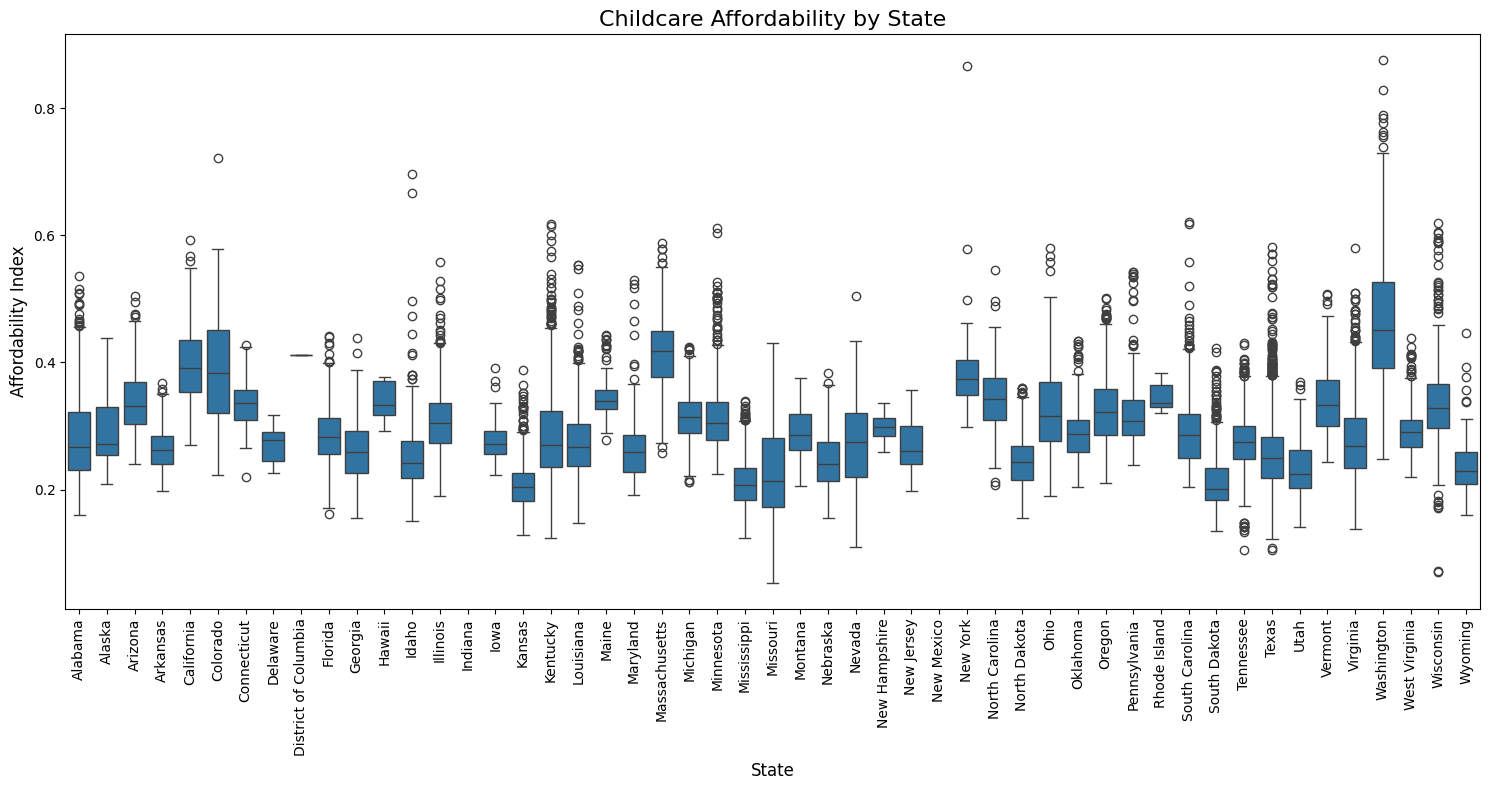


Model Performance:
Mean Squared Error: 0.0008417367353161944
R-squared Score: 0.8366569260597865

Top Feature Importances:
MHI: 0.11575622380035275
MUNR_20to64: 0.0817302519803353
State_Name_Washington: 0.056748904651494625
State_Abbreviation_WA: 0.05512307666433447
EMP_N: 0.04223959534470739

Policy Recommendations:

Washington:
  Affordability Score: 0.47

Massachusetts:
  Affordability Score: 0.41

District of Columbia:
  Affordability Score: 0.41

California:
  Affordability Score: 0.40

Colorado:
  Affordability Score: 0.39
Exported 2904 counties to affordability_by_county.csv
File size: 75.14 KB


In [13]:
main(df, 'adjusted')
